In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [109]:
def smooth(x, width=5):
    """Smooth an input signal using a size width box filter"""
    
    return np.convolve(x, np.ones(width) / width, 'valid')

def ddx(x):
    """Return the derivative of a signal by convolving an input signal with [-1, 0, 1]"""
    
    return np.convolve(x, [1, 0, -1], 'valid')

def get_tick_time(x):
    """Return the time between ticks for an equally spaced array of ticks
    and their corresponding timestamps.
    """
    
    x = x.to_numpy()
        
    return (x[-1] - x[0]) / (x.size - 1)

In [110]:
big_ddx = 0.01
small_ddx = 0
big_v = 0.9
small_v = 0.05

def fall(seconds, volts, plot=False, width=60):
    """Compute the fall time for a falling signal.
    
    Args:
        - seconds: an array of equally spaced timestamps for each measurement
        - volts: an array of corresponding voltage measurements
        - plot: whether to plot the signal and the detected "falling" region
        - width: a smoothing parameter for the voltage signal
    """
    
    tick_time = get_tick_time(seconds)
    
    s = smooth(volts, width=width)
    d = ddx(s)
                
    start = np.where(d < -big_ddx)[0].min() - 1
    after = d.copy()
    after[:start] = np.NaN
    end = np.where(after > -small_ddx)[0].min() - 1
    
    if plot:
        plt.plot(seconds, volts)
        plt.plot(seconds[start + width // 2: end + width // 2], volts[start + width // 2: end + width // 2])
        plt.figure()
    
    return (end - start) * tick_time * 1000000


def rise(seconds, volts, plot=False, width=60, big_ddx=big_ddx):
    """Compute the fall time for a falling signal.
    
    Args:
        - seconds: an array of equally spaced timestamps for each measurement
        - volts: an array of corresponding voltage measurements
        - plot: whether to plot the signal and the detected "falling" region
        - width: a smoothing parameter for the voltage signal
        - big_ddx: a threshold for a large derivative magnitude
    """
    
    tick_time = get_tick_time(seconds)
    
    s = smooth(volts, width=width)
    d = ddx(s)
                            
    start = np.where(d > big_ddx)[0].min() - 1
    start_high = np.where(s > big_v)[0].min()
    after = d.copy()
    after[:start_high] = np.NaN
    end = np.where(after < small_ddx)[0].min() - 1
    
    if plot:
        plt.plot(seconds, volts)
        plt.plot(seconds[start + width // 2: end + width // 2], volts[start + width // 2: end + width // 2])
        plt.figure()
    
    return (end - start) * tick_time * 1000000

In [111]:
def read_and_normalize(file):
    """Read a .csv of voltage measurements from a scope.
    
    Normalize voltage measurements to around 0 -> 1.
    
    The file should contain headers 'second', 'Volt' and corresponding
    measurement pairs.    
    """
    
    df = pd.read_csv(os.path.join(file), header=1)
    df.apply(pd.to_numeric)

    # Truncate sides for NaN measurements
    seconds = df['second'][5:-5]
    volts = df['Volt'][5:-5]
        
    volts -= np.min(smooth(volts, 40))
    volts /= np.max(smooth(volts, 40))
    
    return seconds, volts


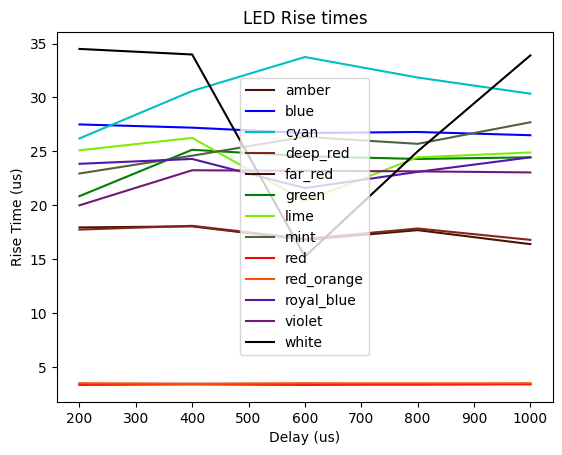

In [112]:
# Plot the rise times for each LED

colors = ['amber', 'blue', 'cyan', 'deep_red', 'far_red', 'green', 'lime',
          'mint', 'red', 'red_orange', 'royal_blue', 'violet', 'white']

graph_colors = ['#451404', 'b', 'c', '#85231c', '#3d0f0c', 'g', '#80eb07',
                '#52613c', 'r', '#ff5100', '#5215ad', '#711a75', 'black']

plt.figure()
plt.title("LED Rise times")
plt.xlabel("Delay (us)")
plt.ylabel("Rise Time (us)")

for color, gc in zip(colors, graph_colors):
    rises = []
    
    for delay in [200, 400, 600, 800, 1000]:
        seconds, volts = read_file(f'./data/{color}/{delay}_rise.csv')
        
        if color == 'white':
            rises.append(rise(seconds, volts, False, width=200, big_ddx=0.005))
        else:
            rises.append(rise(seconds, volts, False))
                        
    plt.plot([200, 400, 600, 800, 1000], rises, label=color, color=gc)
    
plt.legend()

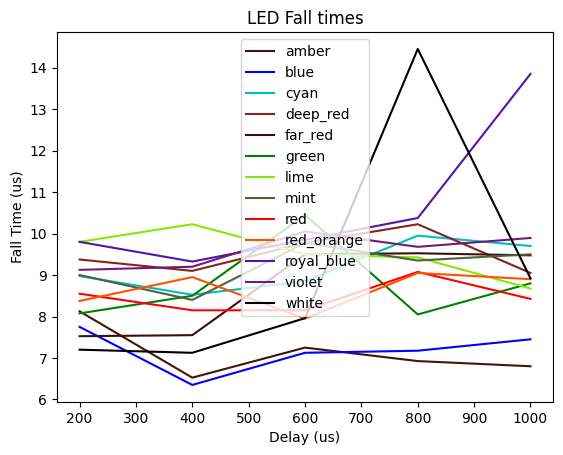

In [113]:
plt.figure()
plt.title("LED Fall times")
plt.xlabel("Delay (us)")
plt.ylabel("Fall Time (us)")

for color, gc in zip(colors, graph_colors):
    falls = []
    
    for delay in [200, 400, 600, 800, 1000]:
        seconds, volts = read_file(f'./data/{color}/{delay}_fall.csv')
        
        if color == 'white':
            falls.append(fall(seconds, volts, False, width=100))
        else:
            falls.append(fall(seconds, volts, False))
                        
    plt.plot([200, 400, 600, 800, 1000], falls, label=color, color=gc)
    
plt.legend()